# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [36]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [37]:
from datetime import datetime

flist = ['GunPoint'] # List dataset directory names.
batch_size = 64 # Or Wang setting can be set below as int(min(x_train.shape[0]/10, 16)) 
nb_epochs = 5000
k = 1 # For k-fold cross validation. If k=1, the original test-train split is used.
m = 1 # Number of repetitions of k-fold cross validation (if k>1).
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
tensorboard = False # Set to True to write logs for use by TensorBoard
# Directories
fdir = '../data'  
logs_dir = '../logs'
tensorboard_dir = '../logs/tensorboard'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [38]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RepeatedKFold

import os
import pathlib
import time

np.random.seed(22)#813306)
      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  

### Visualise the data

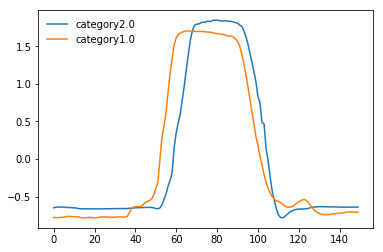

In [39]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [40]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    #batch_size = int(min(x_train.shape[0]/10, 16)) # Wang et al. setting.
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
  
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
    
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    callbacks = [reduce_lr]
    if tensorboard:
        callbacks = [reduce_lr, keras.callbacks.TensorBoard(log_dir=tensorboard_dir+'/'+fname+'_'+label, histogram_freq=0)]

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), callbacks=callbacks)
    end = time.time()
    
    log = pd.DataFrame(hist.history)   
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    duration_minutes = str(round((end-start)/60))
    print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')    
    print('Selected the test result with the lowest training loss. Loss and validation accuracy are -')
    idx = log['loss'].idxmin()
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc, 'at index', str(idx), ' (epoch ', str(idx+1), ')')
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+str(idx)+' |'+ duration_minutes + 'mins  |'
    summary_csv = label+','+str(loss)+','+str(val_acc)+','+str(idx)+','+ duration_minutes 
    # Save summary file and log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    with open(logs_dir+'/'+fname+'/summary.csv', 'a+') as f:
        f.write(summary_csv)
        f.write('\n')
        print('Added summary row to ', logs_dir+'/'+fname+'/summary.csv')  
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    return summary, model
 



# Train

In [41]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        #kfold = KFold(k, True, k_fold_seed)
        kfold = RepeatedKFold(n_splits=k, n_repeats=m, random_state=k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary, model = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary, model = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
print(fname, timestamp)
for each in results:
    print(each)
	

Running dataset GunPoint
Train on 50 samples, validate on 150 samples
Epoch 1/5000
 - 0s - loss: 0.6896 - acc: 0.5600 - val_loss: 0.6883 - val_acc: 0.5533
Epoch 2/5000
 - 0s - loss: 0.6841 - acc: 0.6800 - val_loss: 0.6780 - val_acc: 0.6800
Epoch 3/5000
 - 0s - loss: 0.6690 - acc: 0.7600 - val_loss: 0.6678 - val_acc: 0.7000
Epoch 4/5000
 - 0s - loss: 0.6626 - acc: 0.7200 - val_loss: 0.6555 - val_acc: 0.7467
Epoch 5/5000
 - 0s - loss: 0.6437 - acc: 0.8200 - val_loss: 0.6426 - val_acc: 0.7400
Epoch 6/5000
 - 0s - loss: 0.6251 - acc: 0.7800 - val_loss: 0.6232 - val_acc: 0.7867
Epoch 7/5000
 - 0s - loss: 0.6108 - acc: 0.8400 - val_loss: 0.6048 - val_acc: 0.7267
Epoch 8/5000
 - 0s - loss: 0.5832 - acc: 0.8400 - val_loss: 0.5824 - val_acc: 0.7467
Epoch 9/5000
 - 0s - loss: 0.5463 - acc: 0.8400 - val_loss: 0.5543 - val_acc: 0.8200
Epoch 10/5000
 - 0s - loss: 0.5166 - acc: 0.7800 - val_loss: 0.5379 - val_acc: 0.6800
Epoch 11/5000
 - 0s - loss: 0.4575 - acc: 0.9000 - val_loss: 0.5351 - val_acc: 

Epoch 96/5000
 - 0s - loss: 0.1185 - acc: 0.9400 - val_loss: 0.4026 - val_acc: 0.8067
Epoch 97/5000
 - 0s - loss: 0.1477 - acc: 0.9000 - val_loss: 0.4749 - val_acc: 0.7733
Epoch 98/5000
 - 0s - loss: 0.2085 - acc: 0.9000 - val_loss: 0.4733 - val_acc: 0.7267
Epoch 99/5000
 - 0s - loss: 0.1788 - acc: 0.8600 - val_loss: 0.4147 - val_acc: 0.7800
Epoch 100/5000
 - 0s - loss: 0.2131 - acc: 0.8800 - val_loss: 0.4221 - val_acc: 0.7533
Epoch 101/5000
 - 0s - loss: 0.1627 - acc: 0.9000 - val_loss: 0.3442 - val_acc: 0.8000
Epoch 102/5000
 - 0s - loss: 0.1399 - acc: 0.9200 - val_loss: 0.3791 - val_acc: 0.8067
Epoch 103/5000
 - 0s - loss: 0.1548 - acc: 0.9200 - val_loss: 0.3650 - val_acc: 0.7933
Epoch 104/5000
 - 0s - loss: 0.1497 - acc: 0.9200 - val_loss: 0.3819 - val_acc: 0.7933
Epoch 105/5000
 - 0s - loss: 0.1389 - acc: 0.9400 - val_loss: 0.3755 - val_acc: 0.7933
Epoch 106/5000
 - 0s - loss: 0.1579 - acc: 0.9000 - val_loss: 0.4130 - val_acc: 0.7800
Epoch 107/5000
 - 0s - loss: 0.1433 - acc: 0.90

Epoch 191/5000
 - 0s - loss: 0.0310 - acc: 1.0000 - val_loss: 0.3247 - val_acc: 0.9000
Epoch 192/5000
 - 0s - loss: 0.0365 - acc: 0.9800 - val_loss: 0.3159 - val_acc: 0.8600
Epoch 193/5000
 - 0s - loss: 0.0807 - acc: 0.9600 - val_loss: 0.6989 - val_acc: 0.7533
Epoch 194/5000
 - 0s - loss: 0.2231 - acc: 0.8600 - val_loss: 1.1691 - val_acc: 0.7067
Epoch 195/5000
 - 0s - loss: 0.6098 - acc: 0.8200 - val_loss: 0.3302 - val_acc: 0.8933
Epoch 196/5000
 - 0s - loss: 0.0632 - acc: 0.9800 - val_loss: 0.2626 - val_acc: 0.9000
Epoch 197/5000
 - 0s - loss: 0.0448 - acc: 1.0000 - val_loss: 0.2618 - val_acc: 0.9267
Epoch 198/5000
 - 0s - loss: 0.0404 - acc: 1.0000 - val_loss: 0.2530 - val_acc: 0.9200
Epoch 199/5000
 - 0s - loss: 0.0345 - acc: 1.0000 - val_loss: 0.2606 - val_acc: 0.9333
Epoch 200/5000
 - 0s - loss: 0.0259 - acc: 1.0000 - val_loss: 0.2398 - val_acc: 0.9267
Epoch 201/5000
 - 0s - loss: 0.0297 - acc: 1.0000 - val_loss: 0.2552 - val_acc: 0.9333
Epoch 202/5000
 - 0s - loss: 0.0289 - acc: 

 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2689 - val_acc: 0.9333
Epoch 286/5000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.2545 - val_acc: 0.9400
Epoch 287/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.2657 - val_acc: 0.9400
Epoch 288/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2622 - val_acc: 0.9467
Epoch 289/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.2617 - val_acc: 0.9400
Epoch 290/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.2555 - val_acc: 0.9400
Epoch 291/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.2612 - val_acc: 0.9467
Epoch 292/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.2636 - val_acc: 0.9467
Epoch 293/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.2799 - val_acc: 0.9267
Epoch 294/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2646 - val_acc: 0.9467
Epoch 295/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2650 - val_acc: 0.9467
Epoch 296/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_lo

Epoch 378/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.2839 - val_acc: 0.9467
Epoch 379/5000
 - 0s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4076 - val_acc: 0.9133
Epoch 380/5000
 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.2872 - val_acc: 0.9400
Epoch 381/5000
 - 0s - loss: 3.8097e-04 - acc: 1.0000 - val_loss: 0.2874 - val_acc: 0.9467
Epoch 382/5000
 - 0s - loss: 9.9395e-04 - acc: 1.0000 - val_loss: 0.3035 - val_acc: 0.9400
Epoch 383/5000
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.3208 - val_acc: 0.9200
Epoch 384/5000
 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.3205 - val_acc: 0.9267
Epoch 385/5000
 - 0s - loss: 4.7104e-04 - acc: 1.0000 - val_loss: 0.2967 - val_acc: 0.9333
Epoch 386/5000
 - 0s - loss: 3.1883e-04 - acc: 1.0000 - val_loss: 0.2931 - val_acc: 0.9467
Epoch 387/5000
 - 0s - loss: 3.7220e-04 - acc: 1.0000 - val_loss: 0.2921 - val_acc: 0.9533
Epoch 388/5000
 - 0s - loss: 3.4407e-04 - acc: 1.0000 - val_loss: 0.2863 - val_acc: 0.9467
Epoch 389/5000
 - 0

Epoch 471/5000
 - 0s - loss: 3.9786e-04 - acc: 1.0000 - val_loss: 0.2678 - val_acc: 0.9467
Epoch 472/5000
 - 0s - loss: 9.5117e-04 - acc: 1.0000 - val_loss: 0.2688 - val_acc: 0.9467
Epoch 473/5000
 - 0s - loss: 9.0159e-04 - acc: 1.0000 - val_loss: 0.2694 - val_acc: 0.9467
Epoch 474/5000
 - 0s - loss: 7.8012e-04 - acc: 1.0000 - val_loss: 0.2697 - val_acc: 0.9467
Epoch 475/5000
 - 0s - loss: 5.4403e-04 - acc: 1.0000 - val_loss: 0.2702 - val_acc: 0.9467
Epoch 476/5000
 - 0s - loss: 7.3166e-04 - acc: 1.0000 - val_loss: 0.2705 - val_acc: 0.9467
Epoch 477/5000
 - 0s - loss: 5.3683e-04 - acc: 1.0000 - val_loss: 0.2708 - val_acc: 0.9467
Epoch 478/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2713 - val_acc: 0.9467
Epoch 479/5000
 - 0s - loss: 6.4645e-04 - acc: 1.0000 - val_loss: 0.2717 - val_acc: 0.9467
Epoch 480/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2730 - val_acc: 0.9467
Epoch 481/5000
 - 0s - loss: 5.6188e-04 - acc: 1.0000 - val_loss: 0.2737 - val_acc: 0.9467
Epoch 4

Epoch 562/5000
 - 0s - loss: 2.6160e-04 - acc: 1.0000 - val_loss: 0.2815 - val_acc: 0.9467
Epoch 563/5000
 - 0s - loss: 1.1705e-04 - acc: 1.0000 - val_loss: 0.2822 - val_acc: 0.9467
Epoch 564/5000
 - 0s - loss: 3.1634e-04 - acc: 1.0000 - val_loss: 0.2813 - val_acc: 0.9467
Epoch 565/5000
 - 0s - loss: 8.7726e-04 - acc: 1.0000 - val_loss: 0.3000 - val_acc: 0.9267
Epoch 566/5000
 - 0s - loss: 4.0092e-04 - acc: 1.0000 - val_loss: 0.2940 - val_acc: 0.9400
Epoch 567/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.3047 - val_acc: 0.9333
Epoch 568/5000
 - 0s - loss: 1.6268e-04 - acc: 1.0000 - val_loss: 0.3012 - val_acc: 0.9333
Epoch 569/5000
 - 0s - loss: 2.6376e-04 - acc: 1.0000 - val_loss: 0.2976 - val_acc: 0.9333
Epoch 570/5000
 - 0s - loss: 2.2478e-04 - acc: 1.0000 - val_loss: 0.2968 - val_acc: 0.9333
Epoch 571/5000
 - 0s - loss: 2.4393e-04 - acc: 1.0000 - val_loss: 0.2929 - val_acc: 0.9400
Epoch 572/5000
 - 0s - loss: 2.4233e-04 - acc: 1.0000 - val_loss: 0.2922 - val_acc: 0.9400
Epo

 - 0s - loss: 2.4333e-04 - acc: 1.0000 - val_loss: 0.3580 - val_acc: 0.9333
Epoch 653/5000
 - 0s - loss: 8.5133e-05 - acc: 1.0000 - val_loss: 0.3527 - val_acc: 0.9400
Epoch 654/5000
 - 0s - loss: 6.4708e-05 - acc: 1.0000 - val_loss: 0.3484 - val_acc: 0.9400
Epoch 655/5000
 - 0s - loss: 9.5478e-05 - acc: 1.0000 - val_loss: 0.3501 - val_acc: 0.9400
Epoch 656/5000
 - 0s - loss: 1.0368e-04 - acc: 1.0000 - val_loss: 0.3419 - val_acc: 0.9400
Epoch 657/5000
 - 0s - loss: 1.3451e-04 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9400
Epoch 658/5000
 - 0s - loss: 1.3107e-04 - acc: 1.0000 - val_loss: 0.3479 - val_acc: 0.9400
Epoch 659/5000
 - 0s - loss: 7.6645e-05 - acc: 1.0000 - val_loss: 0.3429 - val_acc: 0.9400
Epoch 660/5000
 - 0s - loss: 8.8346e-05 - acc: 1.0000 - val_loss: 0.3400 - val_acc: 0.9400
Epoch 661/5000
 - 0s - loss: 4.0213e-04 - acc: 1.0000 - val_loss: 0.3905 - val_acc: 0.9200
Epoch 662/5000
 - 0s - loss: 9.1727e-05 - acc: 1.0000 - val_loss: 0.3736 - val_acc: 0.9333
Epoch 663/5000

Epoch 743/5000
 - 0s - loss: 1.0287e-04 - acc: 1.0000 - val_loss: 0.2872 - val_acc: 0.9467
Epoch 744/5000
 - 0s - loss: 6.1050e-05 - acc: 1.0000 - val_loss: 0.2836 - val_acc: 0.9467
Epoch 745/5000
 - 0s - loss: 3.4966e-05 - acc: 1.0000 - val_loss: 0.2812 - val_acc: 0.9467
Epoch 746/5000
 - 0s - loss: 7.6357e-04 - acc: 1.0000 - val_loss: 0.3864 - val_acc: 0.9133
Epoch 747/5000
 - 0s - loss: 2.9380e-04 - acc: 1.0000 - val_loss: 0.3321 - val_acc: 0.9200
Epoch 748/5000
 - 0s - loss: 2.6994e-04 - acc: 1.0000 - val_loss: 0.3078 - val_acc: 0.9200
Epoch 749/5000
 - 0s - loss: 1.2367e-04 - acc: 1.0000 - val_loss: 0.2969 - val_acc: 0.9400
Epoch 750/5000
 - 0s - loss: 7.5667e-05 - acc: 1.0000 - val_loss: 0.2914 - val_acc: 0.9400
Epoch 751/5000
 - 0s - loss: 5.7513e-05 - acc: 1.0000 - val_loss: 0.2895 - val_acc: 0.9400
Epoch 752/5000
 - 0s - loss: 4.4685e-05 - acc: 1.0000 - val_loss: 0.2898 - val_acc: 0.9400
Epoch 753/5000
 - 0s - loss: 4.4549e-05 - acc: 1.0000 - val_loss: 0.2914 - val_acc: 0.9400

 - 0s - loss: 1.2031e-04 - acc: 1.0000 - val_loss: 0.3042 - val_acc: 0.9400
Epoch 834/5000
 - 0s - loss: 1.3357e-04 - acc: 1.0000 - val_loss: 0.2975 - val_acc: 0.9400
Epoch 835/5000
 - 0s - loss: 4.6326e-05 - acc: 1.0000 - val_loss: 0.2987 - val_acc: 0.9400
Epoch 836/5000
 - 0s - loss: 6.7600e-05 - acc: 1.0000 - val_loss: 0.3008 - val_acc: 0.9400
Epoch 837/5000
 - 0s - loss: 1.0626e-04 - acc: 1.0000 - val_loss: 0.2975 - val_acc: 0.9400
Epoch 838/5000
 - 0s - loss: 9.9747e-05 - acc: 1.0000 - val_loss: 0.2969 - val_acc: 0.9400
Epoch 839/5000
 - 0s - loss: 3.0999e-04 - acc: 1.0000 - val_loss: 0.3179 - val_acc: 0.9400
Epoch 840/5000
 - 0s - loss: 1.7109e-05 - acc: 1.0000 - val_loss: 0.3172 - val_acc: 0.9400
Epoch 841/5000
 - 0s - loss: 2.9611e-05 - acc: 1.0000 - val_loss: 0.3163 - val_acc: 0.9400
Epoch 842/5000
 - 0s - loss: 1.8888e-05 - acc: 1.0000 - val_loss: 0.3163 - val_acc: 0.9400
Epoch 843/5000
 - 0s - loss: 2.3029e-04 - acc: 1.0000 - val_loss: 0.3014 - val_acc: 0.9400
Epoch 844/5000

Epoch 924/5000
 - 0s - loss: 1.9350e-05 - acc: 1.0000 - val_loss: 0.3112 - val_acc: 0.9400
Epoch 925/5000
 - 0s - loss: 2.9287e-05 - acc: 1.0000 - val_loss: 0.3111 - val_acc: 0.9400
Epoch 926/5000
 - 0s - loss: 6.5248e-05 - acc: 1.0000 - val_loss: 0.3110 - val_acc: 0.9400
Epoch 927/5000
 - 0s - loss: 1.6007e-04 - acc: 1.0000 - val_loss: 0.3101 - val_acc: 0.9400
Epoch 928/5000
 - 0s - loss: 4.9471e-05 - acc: 1.0000 - val_loss: 0.3110 - val_acc: 0.9400
Epoch 929/5000
 - 0s - loss: 4.8382e-05 - acc: 1.0000 - val_loss: 0.3116 - val_acc: 0.9400
Epoch 930/5000
 - 0s - loss: 1.1578e-04 - acc: 1.0000 - val_loss: 0.3197 - val_acc: 0.9400
Epoch 931/5000
 - 0s - loss: 1.2605e-04 - acc: 1.0000 - val_loss: 0.3225 - val_acc: 0.9400
Epoch 932/5000
 - 0s - loss: 4.0560e-05 - acc: 1.0000 - val_loss: 0.3212 - val_acc: 0.9400
Epoch 933/5000
 - 0s - loss: 2.8409e-05 - acc: 1.0000 - val_loss: 0.3211 - val_acc: 0.9400
Epoch 934/5000
 - 0s - loss: 2.2931e-05 - acc: 1.0000 - val_loss: 0.3209 - val_acc: 0.9400

Epoch 1014/5000
 - 0s - loss: 1.2794e-05 - acc: 1.0000 - val_loss: 0.3260 - val_acc: 0.9400
Epoch 1015/5000
 - 0s - loss: 2.8921e-05 - acc: 1.0000 - val_loss: 0.3264 - val_acc: 0.9400
Epoch 1016/5000
 - 0s - loss: 5.3031e-05 - acc: 1.0000 - val_loss: 0.3256 - val_acc: 0.9400
Epoch 1017/5000
 - 0s - loss: 3.9554e-05 - acc: 1.0000 - val_loss: 0.3254 - val_acc: 0.9400
Epoch 1018/5000
 - 0s - loss: 2.8074e-05 - acc: 1.0000 - val_loss: 0.3249 - val_acc: 0.9400
Epoch 1019/5000
 - 0s - loss: 1.7847e-05 - acc: 1.0000 - val_loss: 0.3250 - val_acc: 0.9400
Epoch 1020/5000
 - 0s - loss: 3.0649e-05 - acc: 1.0000 - val_loss: 0.3258 - val_acc: 0.9400
Epoch 1021/5000
 - 0s - loss: 4.7436e-05 - acc: 1.0000 - val_loss: 0.3266 - val_acc: 0.9400
Epoch 1022/5000
 - 0s - loss: 5.6276e-05 - acc: 1.0000 - val_loss: 0.3285 - val_acc: 0.9400
Epoch 1023/5000
 - 0s - loss: 8.1956e-05 - acc: 1.0000 - val_loss: 0.3266 - val_acc: 0.9400
Epoch 1024/5000
 - 0s - loss: 1.0912e-05 - acc: 1.0000 - val_loss: 0.3269 - val_

 - 0s - loss: 2.4044e-05 - acc: 1.0000 - val_loss: 0.3388 - val_acc: 0.9400
Epoch 1104/5000
 - 0s - loss: 4.8920e-05 - acc: 1.0000 - val_loss: 0.3383 - val_acc: 0.9400
Epoch 1105/5000
 - 0s - loss: 5.4983e-05 - acc: 1.0000 - val_loss: 0.3366 - val_acc: 0.9400
Epoch 1106/5000
 - 0s - loss: 1.7402e-04 - acc: 1.0000 - val_loss: 0.3411 - val_acc: 0.9400
Epoch 1107/5000
 - 0s - loss: 3.4840e-05 - acc: 1.0000 - val_loss: 0.3398 - val_acc: 0.9400
Epoch 1108/5000
 - 0s - loss: 7.8181e-06 - acc: 1.0000 - val_loss: 0.3399 - val_acc: 0.9400
Epoch 1109/5000
 - 0s - loss: 2.2553e-05 - acc: 1.0000 - val_loss: 0.3391 - val_acc: 0.9400
Epoch 1110/5000
 - 0s - loss: 2.4496e-05 - acc: 1.0000 - val_loss: 0.3390 - val_acc: 0.9400
Epoch 1111/5000
 - 0s - loss: 2.8840e-05 - acc: 1.0000 - val_loss: 0.3384 - val_acc: 0.9400
Epoch 1112/5000
 - 0s - loss: 1.9647e-05 - acc: 1.0000 - val_loss: 0.3382 - val_acc: 0.9400
Epoch 1113/5000
 - 0s - loss: 6.4973e-05 - acc: 1.0000 - val_loss: 0.3406 - val_acc: 0.9400
Epoc

Epoch 1193/5000
 - 0s - loss: 5.6612e-05 - acc: 1.0000 - val_loss: 0.3339 - val_acc: 0.9400
Epoch 1194/5000
 - 0s - loss: 1.8976e-05 - acc: 1.0000 - val_loss: 0.3339 - val_acc: 0.9400
Epoch 1195/5000
 - 0s - loss: 5.0806e-05 - acc: 1.0000 - val_loss: 0.3346 - val_acc: 0.9400
Epoch 1196/5000
 - 0s - loss: 1.5345e-05 - acc: 1.0000 - val_loss: 0.3344 - val_acc: 0.9400
Epoch 1197/5000
 - 0s - loss: 2.9259e-05 - acc: 1.0000 - val_loss: 0.3343 - val_acc: 0.9400
Epoch 1198/5000
 - 0s - loss: 2.6566e-05 - acc: 1.0000 - val_loss: 0.3339 - val_acc: 0.9400
Epoch 1199/5000
 - 0s - loss: 5.2134e-05 - acc: 1.0000 - val_loss: 0.3339 - val_acc: 0.9400
Epoch 1200/5000
 - 0s - loss: 3.5216e-05 - acc: 1.0000 - val_loss: 0.3338 - val_acc: 0.9400
Epoch 1201/5000
 - 0s - loss: 1.2059e-05 - acc: 1.0000 - val_loss: 0.3339 - val_acc: 0.9400
Epoch 1202/5000
 - 0s - loss: 2.2777e-05 - acc: 1.0000 - val_loss: 0.3341 - val_acc: 0.9400
Epoch 1203/5000
 - 0s - loss: 1.3095e-04 - acc: 1.0000 - val_loss: 0.3330 - val_

 - 0s - loss: 2.0279e-05 - acc: 1.0000 - val_loss: 0.3384 - val_acc: 0.9400
Epoch 1283/5000
 - 0s - loss: 5.7310e-05 - acc: 1.0000 - val_loss: 0.3388 - val_acc: 0.9400
Epoch 1284/5000
 - 0s - loss: 1.6908e-05 - acc: 1.0000 - val_loss: 0.3387 - val_acc: 0.9400
Epoch 1285/5000
 - 0s - loss: 2.5242e-05 - acc: 1.0000 - val_loss: 0.3387 - val_acc: 0.9400
Epoch 1286/5000
 - 0s - loss: 7.9361e-06 - acc: 1.0000 - val_loss: 0.3387 - val_acc: 0.9400
Epoch 1287/5000
 - 0s - loss: 4.5222e-05 - acc: 1.0000 - val_loss: 0.3394 - val_acc: 0.9400
Epoch 1288/5000
 - 0s - loss: 3.0728e-05 - acc: 1.0000 - val_loss: 0.3391 - val_acc: 0.9400
Epoch 1289/5000
 - 0s - loss: 2.6822e-05 - acc: 1.0000 - val_loss: 0.3394 - val_acc: 0.9400
Epoch 1290/5000
 - 0s - loss: 1.7570e-05 - acc: 1.0000 - val_loss: 0.3393 - val_acc: 0.9400
Epoch 1291/5000
 - 0s - loss: 5.5329e-05 - acc: 1.0000 - val_loss: 0.3382 - val_acc: 0.9400
Epoch 1292/5000
 - 0s - loss: 2.9603e-05 - acc: 1.0000 - val_loss: 0.3378 - val_acc: 0.9400
Epoc

Epoch 1372/5000
 - 0s - loss: 1.1287e-04 - acc: 1.0000 - val_loss: 0.3407 - val_acc: 0.9400
Epoch 1373/5000
 - 0s - loss: 1.9409e-05 - acc: 1.0000 - val_loss: 0.3408 - val_acc: 0.9400
Epoch 1374/5000
 - 0s - loss: 2.8212e-05 - acc: 1.0000 - val_loss: 0.3411 - val_acc: 0.9400
Epoch 1375/5000
 - 0s - loss: 2.7484e-05 - acc: 1.0000 - val_loss: 0.3410 - val_acc: 0.9400
Epoch 1376/5000
 - 0s - loss: 3.3513e-05 - acc: 1.0000 - val_loss: 0.3408 - val_acc: 0.9400
Epoch 1377/5000
 - 0s - loss: 4.5814e-05 - acc: 1.0000 - val_loss: 0.3403 - val_acc: 0.9400
Epoch 1378/5000
 - 0s - loss: 1.4038e-05 - acc: 1.0000 - val_loss: 0.3405 - val_acc: 0.9400
Epoch 1379/5000
 - 0s - loss: 5.8243e-05 - acc: 1.0000 - val_loss: 0.3413 - val_acc: 0.9400
Epoch 1380/5000
 - 0s - loss: 3.1525e-05 - acc: 1.0000 - val_loss: 0.3418 - val_acc: 0.9400
Epoch 1381/5000
 - 0s - loss: 2.3196e-05 - acc: 1.0000 - val_loss: 0.3417 - val_acc: 0.9400
Epoch 1382/5000
 - 0s - loss: 2.8913e-05 - acc: 1.0000 - val_loss: 0.3418 - val_

 - 0s - loss: 2.3176e-05 - acc: 1.0000 - val_loss: 0.3427 - val_acc: 0.9400
Epoch 1462/5000
 - 0s - loss: 9.3382e-05 - acc: 1.0000 - val_loss: 0.3426 - val_acc: 0.9400
Epoch 1463/5000
 - 0s - loss: 3.5892e-05 - acc: 1.0000 - val_loss: 0.3423 - val_acc: 0.9400
Epoch 1464/5000
 - 0s - loss: 1.6549e-05 - acc: 1.0000 - val_loss: 0.3422 - val_acc: 0.9400
Epoch 1465/5000
 - 0s - loss: 3.7520e-05 - acc: 1.0000 - val_loss: 0.3424 - val_acc: 0.9400
Epoch 1466/5000
 - 0s - loss: 1.9702e-04 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9400
Epoch 1467/5000
 - 0s - loss: 1.5500e-05 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9400
Epoch 1468/5000
 - 0s - loss: 1.3500e-05 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9400
Epoch 1469/5000
 - 0s - loss: 2.4576e-05 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9400
Epoch 1470/5000
 - 0s - loss: 2.0888e-05 - acc: 1.0000 - val_loss: 0.3454 - val_acc: 0.9400
Epoch 1471/5000
 - 0s - loss: 2.5890e-05 - acc: 1.0000 - val_loss: 0.3451 - val_acc: 0.9400
Epoc

Epoch 1551/5000
 - 0s - loss: 1.4366e-05 - acc: 1.0000 - val_loss: 0.3458 - val_acc: 0.9400
Epoch 1552/5000
 - 0s - loss: 2.8276e-05 - acc: 1.0000 - val_loss: 0.3460 - val_acc: 0.9400
Epoch 1553/5000
 - 0s - loss: 1.7582e-05 - acc: 1.0000 - val_loss: 0.3459 - val_acc: 0.9400
Epoch 1554/5000
 - 0s - loss: 2.3295e-05 - acc: 1.0000 - val_loss: 0.3459 - val_acc: 0.9400
Epoch 1555/5000
 - 0s - loss: 2.1617e-05 - acc: 1.0000 - val_loss: 0.3457 - val_acc: 0.9400
Epoch 1556/5000
 - 0s - loss: 3.3436e-05 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9400
Epoch 1557/5000
 - 0s - loss: 2.6936e-05 - acc: 1.0000 - val_loss: 0.3454 - val_acc: 0.9400
Epoch 1558/5000
 - 0s - loss: 1.7489e-05 - acc: 1.0000 - val_loss: 0.3454 - val_acc: 0.9400
Epoch 1559/5000
 - 0s - loss: 8.8435e-05 - acc: 1.0000 - val_loss: 0.3456 - val_acc: 0.9400
Epoch 1560/5000
 - 0s - loss: 2.1479e-05 - acc: 1.0000 - val_loss: 0.3457 - val_acc: 0.9400
Epoch 1561/5000
 - 0s - loss: 3.2312e-05 - acc: 1.0000 - val_loss: 0.3459 - val_

 - 0s - loss: 3.2325e-05 - acc: 1.0000 - val_loss: 0.3541 - val_acc: 0.9400
Epoch 1641/5000
 - 0s - loss: 1.9722e-05 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9400
Epoch 1642/5000
 - 0s - loss: 4.1864e-05 - acc: 1.0000 - val_loss: 0.3537 - val_acc: 0.9400
Epoch 1643/5000
 - 0s - loss: 3.5184e-05 - acc: 1.0000 - val_loss: 0.3536 - val_acc: 0.9400
Epoch 1644/5000
 - 0s - loss: 8.9509e-05 - acc: 1.0000 - val_loss: 0.3528 - val_acc: 0.9400
Epoch 1645/5000
 - 0s - loss: 6.2179e-05 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9400
Epoch 1646/5000
 - 0s - loss: 3.5877e-05 - acc: 1.0000 - val_loss: 0.3537 - val_acc: 0.9400
Epoch 1647/5000
 - 0s - loss: 2.8674e-05 - acc: 1.0000 - val_loss: 0.3536 - val_acc: 0.9400
Epoch 1648/5000
 - 0s - loss: 2.1936e-05 - acc: 1.0000 - val_loss: 0.3537 - val_acc: 0.9400
Epoch 1649/5000
 - 0s - loss: 4.0886e-05 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9400
Epoch 1650/5000
 - 0s - loss: 6.0741e-05 - acc: 1.0000 - val_loss: 0.3535 - val_acc: 0.9400
Epoc

Epoch 1730/5000
 - 0s - loss: 1.0061e-05 - acc: 1.0000 - val_loss: 0.3486 - val_acc: 0.9400
Epoch 1731/5000
 - 0s - loss: 1.7138e-05 - acc: 1.0000 - val_loss: 0.3485 - val_acc: 0.9400
Epoch 1732/5000
 - 0s - loss: 5.2930e-05 - acc: 1.0000 - val_loss: 0.3483 - val_acc: 0.9400
Epoch 1733/5000
 - 0s - loss: 3.2987e-05 - acc: 1.0000 - val_loss: 0.3481 - val_acc: 0.9400
Epoch 1734/5000
 - 0s - loss: 1.6490e-05 - acc: 1.0000 - val_loss: 0.3482 - val_acc: 0.9400
Epoch 1735/5000
 - 0s - loss: 2.2187e-05 - acc: 1.0000 - val_loss: 0.3480 - val_acc: 0.9400
Epoch 1736/5000
 - 0s - loss: 2.3897e-05 - acc: 1.0000 - val_loss: 0.3479 - val_acc: 0.9400
Epoch 1737/5000
 - 0s - loss: 3.9468e-05 - acc: 1.0000 - val_loss: 0.3480 - val_acc: 0.9400
Epoch 1738/5000
 - 0s - loss: 8.4988e-06 - acc: 1.0000 - val_loss: 0.3480 - val_acc: 0.9400
Epoch 1739/5000
 - 0s - loss: 1.8566e-05 - acc: 1.0000 - val_loss: 0.3479 - val_acc: 0.9400
Epoch 1740/5000
 - 0s - loss: 4.7418e-05 - acc: 1.0000 - val_loss: 0.3478 - val_

 - 0s - loss: 1.3580e-05 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9400
Epoch 1820/5000
 - 0s - loss: 7.6284e-06 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9400
Epoch 1821/5000
 - 0s - loss: 3.2334e-05 - acc: 1.0000 - val_loss: 0.3493 - val_acc: 0.9400
Epoch 1822/5000
 - 0s - loss: 2.6711e-05 - acc: 1.0000 - val_loss: 0.3497 - val_acc: 0.9400
Epoch 1823/5000
 - 0s - loss: 1.4538e-05 - acc: 1.0000 - val_loss: 0.3496 - val_acc: 0.9400
Epoch 1824/5000
 - 0s - loss: 4.3926e-05 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9400
Epoch 1825/5000
 - 0s - loss: 1.8971e-05 - acc: 1.0000 - val_loss: 0.3501 - val_acc: 0.9400
Epoch 1826/5000
 - 0s - loss: 8.6334e-06 - acc: 1.0000 - val_loss: 0.3500 - val_acc: 0.9400
Epoch 1827/5000
 - 0s - loss: 2.7021e-05 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9400
Epoch 1828/5000
 - 0s - loss: 1.2481e-05 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9400
Epoch 1829/5000
 - 0s - loss: 4.0740e-05 - acc: 1.0000 - val_loss: 0.3492 - val_acc: 0.9400
Epoc

Epoch 1909/5000
 - 0s - loss: 2.7496e-05 - acc: 1.0000 - val_loss: 0.3515 - val_acc: 0.9400
Epoch 1910/5000
 - 0s - loss: 4.0731e-05 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9400
Epoch 1911/5000
 - 0s - loss: 1.8000e-05 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9400
Epoch 1912/5000
 - 0s - loss: 2.3522e-05 - acc: 1.0000 - val_loss: 0.3513 - val_acc: 0.9400
Epoch 1913/5000
 - 0s - loss: 2.6328e-05 - acc: 1.0000 - val_loss: 0.3513 - val_acc: 0.9400
Epoch 1914/5000
 - 0s - loss: 1.3945e-05 - acc: 1.0000 - val_loss: 0.3513 - val_acc: 0.9400
Epoch 1915/5000
 - 0s - loss: 8.8219e-06 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9400
Epoch 1916/5000
 - 0s - loss: 1.6995e-05 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9400
Epoch 1917/5000
 - 0s - loss: 1.2582e-05 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9400
Epoch 1918/5000
 - 0s - loss: 1.9670e-05 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9400
Epoch 1919/5000
 - 0s - loss: 3.3806e-05 - acc: 1.0000 - val_loss: 0.3511 - val_

 - 0s - loss: 4.6463e-05 - acc: 1.0000 - val_loss: 0.3539 - val_acc: 0.9400
Epoch 1999/5000
 - 0s - loss: 1.5422e-05 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9400
Epoch 2000/5000
 - 0s - loss: 3.5178e-05 - acc: 1.0000 - val_loss: 0.3534 - val_acc: 0.9400
Epoch 2001/5000
 - 0s - loss: 3.3855e-05 - acc: 1.0000 - val_loss: 0.3539 - val_acc: 0.9400
Epoch 2002/5000
 - 0s - loss: 2.4447e-05 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9400
Epoch 2003/5000
 - 0s - loss: 9.5838e-06 - acc: 1.0000 - val_loss: 0.3537 - val_acc: 0.9400
Epoch 2004/5000
 - 0s - loss: 1.4875e-05 - acc: 1.0000 - val_loss: 0.3539 - val_acc: 0.9400
Epoch 2005/5000
 - 0s - loss: 2.8784e-05 - acc: 1.0000 - val_loss: 0.3539 - val_acc: 0.9400
Epoch 2006/5000
 - 0s - loss: 2.6906e-05 - acc: 1.0000 - val_loss: 0.3535 - val_acc: 0.9400
Epoch 2007/5000
 - 0s - loss: 1.2444e-05 - acc: 1.0000 - val_loss: 0.3535 - val_acc: 0.9400
Epoch 2008/5000
 - 0s - loss: 2.0369e-05 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9400
Epoc

Epoch 2088/5000
 - 0s - loss: 1.3696e-05 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9400
Epoch 2089/5000
 - 0s - loss: 1.4938e-05 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9400
Epoch 2090/5000
 - 0s - loss: 1.9418e-05 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9400
Epoch 2091/5000
 - 0s - loss: 1.5071e-05 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9400
Epoch 2092/5000
 - 0s - loss: 3.0996e-05 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9400
Epoch 2093/5000
 - 0s - loss: 3.4583e-05 - acc: 1.0000 - val_loss: 0.3528 - val_acc: 0.9400
Epoch 2094/5000
 - 0s - loss: 2.7225e-05 - acc: 1.0000 - val_loss: 0.3527 - val_acc: 0.9400
Epoch 2095/5000
 - 0s - loss: 9.1115e-06 - acc: 1.0000 - val_loss: 0.3527 - val_acc: 0.9400
Epoch 2096/5000
 - 0s - loss: 1.9909e-05 - acc: 1.0000 - val_loss: 0.3529 - val_acc: 0.9400
Epoch 2097/5000
 - 0s - loss: 3.4063e-05 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9400
Epoch 2098/5000
 - 0s - loss: 1.4188e-05 - acc: 1.0000 - val_loss: 0.3532 - val_

 - 0s - loss: 6.5729e-05 - acc: 1.0000 - val_loss: 0.3556 - val_acc: 0.9400
Epoch 2178/5000
 - 0s - loss: 2.6113e-05 - acc: 1.0000 - val_loss: 0.3553 - val_acc: 0.9400
Epoch 2179/5000
 - 0s - loss: 3.8677e-05 - acc: 1.0000 - val_loss: 0.3556 - val_acc: 0.9400
Epoch 2180/5000
 - 0s - loss: 1.9454e-05 - acc: 1.0000 - val_loss: 0.3555 - val_acc: 0.9400
Epoch 2181/5000
 - 0s - loss: 1.6016e-05 - acc: 1.0000 - val_loss: 0.3553 - val_acc: 0.9400
Epoch 2182/5000
 - 0s - loss: 1.1356e-05 - acc: 1.0000 - val_loss: 0.3553 - val_acc: 0.9400
Epoch 2183/5000
 - 0s - loss: 1.8325e-05 - acc: 1.0000 - val_loss: 0.3550 - val_acc: 0.9400
Epoch 2184/5000
 - 0s - loss: 1.2185e-05 - acc: 1.0000 - val_loss: 0.3549 - val_acc: 0.9400
Epoch 2185/5000
 - 0s - loss: 2.1019e-05 - acc: 1.0000 - val_loss: 0.3550 - val_acc: 0.9400
Epoch 2186/5000
 - 0s - loss: 2.0341e-05 - acc: 1.0000 - val_loss: 0.3553 - val_acc: 0.9400
Epoch 2187/5000
 - 0s - loss: 3.5081e-05 - acc: 1.0000 - val_loss: 0.3553 - val_acc: 0.9400
Epoc

Epoch 2267/5000
 - 0s - loss: 2.2574e-05 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoch 2268/5000
 - 0s - loss: 3.6564e-05 - acc: 1.0000 - val_loss: 0.3588 - val_acc: 0.9400
Epoch 2269/5000
 - 0s - loss: 4.8506e-05 - acc: 1.0000 - val_loss: 0.3596 - val_acc: 0.9400
Epoch 2270/5000
 - 0s - loss: 9.2748e-06 - acc: 1.0000 - val_loss: 0.3596 - val_acc: 0.9400
Epoch 2271/5000
 - 0s - loss: 1.7501e-05 - acc: 1.0000 - val_loss: 0.3596 - val_acc: 0.9400
Epoch 2272/5000
 - 0s - loss: 1.3034e-05 - acc: 1.0000 - val_loss: 0.3596 - val_acc: 0.9400
Epoch 2273/5000
 - 0s - loss: 2.8516e-05 - acc: 1.0000 - val_loss: 0.3600 - val_acc: 0.9400
Epoch 2274/5000
 - 0s - loss: 1.2388e-05 - acc: 1.0000 - val_loss: 0.3600 - val_acc: 0.9400
Epoch 2275/5000
 - 0s - loss: 1.6204e-05 - acc: 1.0000 - val_loss: 0.3599 - val_acc: 0.9400
Epoch 2276/5000
 - 0s - loss: 1.5305e-05 - acc: 1.0000 - val_loss: 0.3598 - val_acc: 0.9400
Epoch 2277/5000
 - 0s - loss: 2.1013e-05 - acc: 1.0000 - val_loss: 0.3598 - val_

 - 0s - loss: 3.8726e-05 - acc: 1.0000 - val_loss: 0.3580 - val_acc: 0.9400
Epoch 2357/5000
 - 0s - loss: 1.8105e-05 - acc: 1.0000 - val_loss: 0.3581 - val_acc: 0.9400
Epoch 2358/5000
 - 0s - loss: 7.2345e-05 - acc: 1.0000 - val_loss: 0.3573 - val_acc: 0.9400
Epoch 2359/5000
 - 0s - loss: 1.3361e-05 - acc: 1.0000 - val_loss: 0.3572 - val_acc: 0.9400
Epoch 2360/5000
 - 0s - loss: 3.3108e-05 - acc: 1.0000 - val_loss: 0.3570 - val_acc: 0.9400
Epoch 2361/5000
 - 0s - loss: 2.3387e-05 - acc: 1.0000 - val_loss: 0.3568 - val_acc: 0.9400
Epoch 2362/5000
 - 0s - loss: 1.9871e-05 - acc: 1.0000 - val_loss: 0.3570 - val_acc: 0.9400
Epoch 2363/5000
 - 0s - loss: 1.0292e-05 - acc: 1.0000 - val_loss: 0.3570 - val_acc: 0.9400
Epoch 2364/5000
 - 0s - loss: 1.5836e-05 - acc: 1.0000 - val_loss: 0.3571 - val_acc: 0.9400
Epoch 2365/5000
 - 0s - loss: 2.6950e-05 - acc: 1.0000 - val_loss: 0.3573 - val_acc: 0.9400
Epoch 2366/5000
 - 0s - loss: 2.0436e-05 - acc: 1.0000 - val_loss: 0.3574 - val_acc: 0.9400
Epoc

Epoch 2446/5000
 - 0s - loss: 1.9239e-05 - acc: 1.0000 - val_loss: 0.3639 - val_acc: 0.9400
Epoch 2447/5000
 - 0s - loss: 3.4141e-05 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9400
Epoch 2448/5000
 - 0s - loss: 9.4609e-06 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9400
Epoch 2449/5000
 - 0s - loss: 5.8306e-06 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9400
Epoch 2450/5000
 - 0s - loss: 2.0743e-05 - acc: 1.0000 - val_loss: 0.3638 - val_acc: 0.9400
Epoch 2451/5000
 - 0s - loss: 5.5944e-05 - acc: 1.0000 - val_loss: 0.3625 - val_acc: 0.9400
Epoch 2452/5000
 - 0s - loss: 9.5122e-06 - acc: 1.0000 - val_loss: 0.3624 - val_acc: 0.9400
Epoch 2453/5000
 - 0s - loss: 4.3589e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 2454/5000
 - 0s - loss: 7.4484e-06 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 2455/5000
 - 0s - loss: 3.0750e-05 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 2456/5000
 - 0s - loss: 9.6448e-06 - acc: 1.0000 - val_loss: 0.3611 - val_

 - 0s - loss: 1.2863e-05 - acc: 1.0000 - val_loss: 0.3618 - val_acc: 0.9400
Epoch 2536/5000
 - 0s - loss: 1.3467e-05 - acc: 1.0000 - val_loss: 0.3617 - val_acc: 0.9400
Epoch 2537/5000
 - 0s - loss: 8.6206e-06 - acc: 1.0000 - val_loss: 0.3617 - val_acc: 0.9400
Epoch 2538/5000
 - 0s - loss: 6.7795e-05 - acc: 1.0000 - val_loss: 0.3630 - val_acc: 0.9400
Epoch 2539/5000
 - 0s - loss: 6.6389e-06 - acc: 1.0000 - val_loss: 0.3630 - val_acc: 0.9400
Epoch 2540/5000
 - 0s - loss: 1.0484e-05 - acc: 1.0000 - val_loss: 0.3629 - val_acc: 0.9400
Epoch 2541/5000
 - 0s - loss: 3.7247e-05 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 2542/5000
 - 0s - loss: 7.0657e-06 - acc: 1.0000 - val_loss: 0.3622 - val_acc: 0.9400
Epoch 2543/5000
 - 0s - loss: 8.4463e-06 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 2544/5000
 - 0s - loss: 4.2914e-05 - acc: 1.0000 - val_loss: 0.3625 - val_acc: 0.9400
Epoch 2545/5000
 - 0s - loss: 1.6490e-05 - acc: 1.0000 - val_loss: 0.3626 - val_acc: 0.9400
Epoc

Epoch 2625/5000
 - 0s - loss: 3.3248e-05 - acc: 1.0000 - val_loss: 0.3638 - val_acc: 0.9400
Epoch 2626/5000
 - 0s - loss: 1.0318e-05 - acc: 1.0000 - val_loss: 0.3637 - val_acc: 0.9400
Epoch 2627/5000
 - 0s - loss: 7.1993e-06 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9400
Epoch 2628/5000
 - 0s - loss: 1.1010e-05 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9400
Epoch 2629/5000
 - 0s - loss: 3.7931e-05 - acc: 1.0000 - val_loss: 0.3635 - val_acc: 0.9400
Epoch 2630/5000
 - 0s - loss: 3.8085e-05 - acc: 1.0000 - val_loss: 0.3632 - val_acc: 0.9400
Epoch 2631/5000
 - 0s - loss: 4.4091e-05 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9400
Epoch 2632/5000
 - 0s - loss: 2.2805e-05 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9400
Epoch 2633/5000
 - 0s - loss: 1.4651e-05 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9400
Epoch 2634/5000
 - 0s - loss: 2.1242e-05 - acc: 1.0000 - val_loss: 0.3637 - val_acc: 0.9400
Epoch 2635/5000
 - 0s - loss: 1.7077e-05 - acc: 1.0000 - val_loss: 0.3635 - val_

 - 0s - loss: 1.7376e-05 - acc: 1.0000 - val_loss: 0.3577 - val_acc: 0.9400
Epoch 2715/5000
 - 0s - loss: 1.7101e-05 - acc: 1.0000 - val_loss: 0.3579 - val_acc: 0.9400
Epoch 2716/5000
 - 0s - loss: 1.9971e-05 - acc: 1.0000 - val_loss: 0.3578 - val_acc: 0.9400
Epoch 2717/5000
 - 0s - loss: 1.2078e-05 - acc: 1.0000 - val_loss: 0.3580 - val_acc: 0.9400
Epoch 2718/5000
 - 0s - loss: 2.0313e-05 - acc: 1.0000 - val_loss: 0.3580 - val_acc: 0.9400
Epoch 2719/5000
 - 0s - loss: 4.3552e-05 - acc: 1.0000 - val_loss: 0.3585 - val_acc: 0.9400
Epoch 2720/5000
 - 0s - loss: 5.6994e-05 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoch 2721/5000
 - 0s - loss: 3.6944e-05 - acc: 1.0000 - val_loss: 0.3600 - val_acc: 0.9400
Epoch 2722/5000
 - 0s - loss: 1.4680e-05 - acc: 1.0000 - val_loss: 0.3601 - val_acc: 0.9400
Epoch 2723/5000
 - 0s - loss: 1.1864e-05 - acc: 1.0000 - val_loss: 0.3601 - val_acc: 0.9400
Epoch 2724/5000
 - 0s - loss: 3.1460e-05 - acc: 1.0000 - val_loss: 0.3603 - val_acc: 0.9400
Epoc

Epoch 2804/5000
 - 0s - loss: 1.4579e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 2805/5000
 - 0s - loss: 1.0777e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 2806/5000
 - 0s - loss: 2.4764e-05 - acc: 1.0000 - val_loss: 0.3621 - val_acc: 0.9400
Epoch 2807/5000
 - 0s - loss: 3.1781e-05 - acc: 1.0000 - val_loss: 0.3622 - val_acc: 0.9400
Epoch 2808/5000
 - 0s - loss: 1.2531e-05 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 2809/5000
 - 0s - loss: 3.1888e-05 - acc: 1.0000 - val_loss: 0.3628 - val_acc: 0.9400
Epoch 2810/5000
 - 0s - loss: 8.6729e-05 - acc: 1.0000 - val_loss: 0.3624 - val_acc: 0.9400
Epoch 2811/5000
 - 0s - loss: 4.2158e-05 - acc: 1.0000 - val_loss: 0.3626 - val_acc: 0.9400
Epoch 2812/5000
 - 0s - loss: 4.8879e-05 - acc: 1.0000 - val_loss: 0.3629 - val_acc: 0.9400
Epoch 2813/5000
 - 0s - loss: 1.5158e-05 - acc: 1.0000 - val_loss: 0.3630 - val_acc: 0.9400
Epoch 2814/5000
 - 0s - loss: 6.0400e-05 - acc: 1.0000 - val_loss: 0.3632 - val_

 - 0s - loss: 2.1770e-05 - acc: 1.0000 - val_loss: 0.3481 - val_acc: 0.9400
Epoch 2894/5000
 - 0s - loss: 9.8024e-05 - acc: 1.0000 - val_loss: 0.3491 - val_acc: 0.9400
Epoch 2895/5000
 - 0s - loss: 3.5707e-05 - acc: 1.0000 - val_loss: 0.3489 - val_acc: 0.9400
Epoch 2896/5000
 - 0s - loss: 2.4786e-05 - acc: 1.0000 - val_loss: 0.3494 - val_acc: 0.9400
Epoch 2897/5000
 - 0s - loss: 5.2385e-05 - acc: 1.0000 - val_loss: 0.3489 - val_acc: 0.9400
Epoch 2898/5000
 - 0s - loss: 1.2304e-05 - acc: 1.0000 - val_loss: 0.3488 - val_acc: 0.9400
Epoch 2899/5000
 - 0s - loss: 4.0453e-05 - acc: 1.0000 - val_loss: 0.3483 - val_acc: 0.9400
Epoch 2900/5000
 - 0s - loss: 2.2620e-05 - acc: 1.0000 - val_loss: 0.3481 - val_acc: 0.9400
Epoch 2901/5000
 - 0s - loss: 1.3207e-05 - acc: 1.0000 - val_loss: 0.3481 - val_acc: 0.9400
Epoch 2902/5000
 - 0s - loss: 1.3551e-05 - acc: 1.0000 - val_loss: 0.3482 - val_acc: 0.9400
Epoch 2903/5000
 - 0s - loss: 1.8594e-05 - acc: 1.0000 - val_loss: 0.3481 - val_acc: 0.9400
Epoc

Epoch 2983/5000
 - 0s - loss: 3.3366e-05 - acc: 1.0000 - val_loss: 0.3494 - val_acc: 0.9400
Epoch 2984/5000
 - 0s - loss: 5.1546e-05 - acc: 1.0000 - val_loss: 0.3487 - val_acc: 0.9400
Epoch 2985/5000
 - 0s - loss: 2.9971e-05 - acc: 1.0000 - val_loss: 0.3487 - val_acc: 0.9400
Epoch 2986/5000
 - 0s - loss: 7.6369e-06 - acc: 1.0000 - val_loss: 0.3486 - val_acc: 0.9400
Epoch 2987/5000
 - 0s - loss: 7.2197e-05 - acc: 1.0000 - val_loss: 0.3495 - val_acc: 0.9400
Epoch 2988/5000
 - 0s - loss: 1.1750e-05 - acc: 1.0000 - val_loss: 0.3495 - val_acc: 0.9400
Epoch 2989/5000
 - 0s - loss: 2.1840e-05 - acc: 1.0000 - val_loss: 0.3493 - val_acc: 0.9400
Epoch 2990/5000
 - 0s - loss: 2.3475e-05 - acc: 1.0000 - val_loss: 0.3494 - val_acc: 0.9400
Epoch 2991/5000
 - 0s - loss: 3.9190e-05 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9400
Epoch 2992/5000
 - 0s - loss: 4.6311e-05 - acc: 1.0000 - val_loss: 0.3493 - val_acc: 0.9400
Epoch 2993/5000
 - 0s - loss: 1.3191e-05 - acc: 1.0000 - val_loss: 0.3493 - val_

Epoch 3073/5000
 - 0s - loss: 1.9293e-05 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9400
Epoch 3074/5000
 - 0s - loss: 2.9279e-05 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9400
Epoch 3075/5000
 - 0s - loss: 4.0142e-05 - acc: 1.0000 - val_loss: 0.3515 - val_acc: 0.9400
Epoch 3076/5000
 - 0s - loss: 3.2064e-05 - acc: 1.0000 - val_loss: 0.3508 - val_acc: 0.9400
Epoch 3077/5000
 - 0s - loss: 2.7185e-05 - acc: 1.0000 - val_loss: 0.3505 - val_acc: 0.9400
Epoch 3078/5000
 - 0s - loss: 1.6720e-05 - acc: 1.0000 - val_loss: 0.3506 - val_acc: 0.9400
Epoch 3079/5000
 - 0s - loss: 1.4053e-05 - acc: 1.0000 - val_loss: 0.3506 - val_acc: 0.9400
Epoch 3080/5000
 - 0s - loss: 1.9070e-05 - acc: 1.0000 - val_loss: 0.3507 - val_acc: 0.9400
Epoch 3081/5000
 - 0s - loss: 6.0166e-06 - acc: 1.0000 - val_loss: 0.3507 - val_acc: 0.9400
Epoch 3082/5000
 - 0s - loss: 1.9025e-05 - acc: 1.0000 - val_loss: 0.3509 - val_acc: 0.9400
Epoch 3083/5000
 - 0s - loss: 6.7595e-06 - acc: 1.0000 - val_loss: 0.3509 - val_

 - 0s - loss: 1.1284e-05 - acc: 1.0000 - val_loss: 0.3535 - val_acc: 0.9400
Epoch 3163/5000
 - 0s - loss: 6.6604e-06 - acc: 1.0000 - val_loss: 0.3535 - val_acc: 0.9400
Epoch 3164/5000
 - 0s - loss: 2.1142e-05 - acc: 1.0000 - val_loss: 0.3535 - val_acc: 0.9400
Epoch 3165/5000
 - 0s - loss: 1.5956e-05 - acc: 1.0000 - val_loss: 0.3534 - val_acc: 0.9400
Epoch 3166/5000
 - 0s - loss: 2.3293e-05 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9400
Epoch 3167/5000
 - 0s - loss: 1.1169e-05 - acc: 1.0000 - val_loss: 0.3534 - val_acc: 0.9400
Epoch 3168/5000
 - 0s - loss: 1.7767e-05 - acc: 1.0000 - val_loss: 0.3534 - val_acc: 0.9400
Epoch 3169/5000
 - 0s - loss: 2.2959e-05 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9400
Epoch 3170/5000
 - 0s - loss: 1.8238e-05 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9400
Epoch 3171/5000
 - 0s - loss: 1.3578e-05 - acc: 1.0000 - val_loss: 0.3534 - val_acc: 0.9400
Epoch 3172/5000
 - 0s - loss: 2.0501e-05 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9400
Epoc

Epoch 3252/5000
 - 0s - loss: 8.9287e-05 - acc: 1.0000 - val_loss: 0.3552 - val_acc: 0.9400
Epoch 3253/5000
 - 0s - loss: 2.5675e-05 - acc: 1.0000 - val_loss: 0.3555 - val_acc: 0.9400
Epoch 3254/5000
 - 0s - loss: 7.9992e-06 - acc: 1.0000 - val_loss: 0.3555 - val_acc: 0.9400
Epoch 3255/5000
 - 0s - loss: 2.1431e-05 - acc: 1.0000 - val_loss: 0.3552 - val_acc: 0.9400
Epoch 3256/5000
 - 0s - loss: 1.0607e-05 - acc: 1.0000 - val_loss: 0.3552 - val_acc: 0.9400
Epoch 3257/5000
 - 0s - loss: 1.9152e-05 - acc: 1.0000 - val_loss: 0.3553 - val_acc: 0.9400
Epoch 3258/5000
 - 0s - loss: 2.7090e-05 - acc: 1.0000 - val_loss: 0.3555 - val_acc: 0.9400
Epoch 3259/5000
 - 0s - loss: 1.1416e-05 - acc: 1.0000 - val_loss: 0.3555 - val_acc: 0.9400
Epoch 3260/5000
 - 0s - loss: 3.3703e-05 - acc: 1.0000 - val_loss: 0.3558 - val_acc: 0.9400
Epoch 3261/5000
 - 0s - loss: 2.6625e-05 - acc: 1.0000 - val_loss: 0.3556 - val_acc: 0.9400
Epoch 3262/5000
 - 0s - loss: 3.7715e-05 - acc: 1.0000 - val_loss: 0.3559 - val_

 - 0s - loss: 1.7581e-05 - acc: 1.0000 - val_loss: 0.3579 - val_acc: 0.9400
Epoch 3342/5000
 - 0s - loss: 1.8623e-05 - acc: 1.0000 - val_loss: 0.3578 - val_acc: 0.9400
Epoch 3343/5000
 - 0s - loss: 1.0553e-05 - acc: 1.0000 - val_loss: 0.3578 - val_acc: 0.9400
Epoch 3344/5000
 - 0s - loss: 9.2953e-06 - acc: 1.0000 - val_loss: 0.3577 - val_acc: 0.9400
Epoch 3345/5000
 - 0s - loss: 1.3259e-05 - acc: 1.0000 - val_loss: 0.3577 - val_acc: 0.9400
Epoch 3346/5000
 - 0s - loss: 3.2361e-05 - acc: 1.0000 - val_loss: 0.3583 - val_acc: 0.9400
Epoch 3347/5000
 - 0s - loss: 1.1858e-05 - acc: 1.0000 - val_loss: 0.3582 - val_acc: 0.9400
Epoch 3348/5000
 - 0s - loss: 4.2024e-05 - acc: 1.0000 - val_loss: 0.3587 - val_acc: 0.9400
Epoch 3349/5000
 - 0s - loss: 3.8158e-05 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoch 3350/5000
 - 0s - loss: 1.5736e-05 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.9400
Epoch 3351/5000
 - 0s - loss: 3.0112e-05 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoc

Epoch 3431/5000
 - 0s - loss: 1.7074e-05 - acc: 1.0000 - val_loss: 0.3583 - val_acc: 0.9400
Epoch 3432/5000
 - 0s - loss: 9.2580e-06 - acc: 1.0000 - val_loss: 0.3583 - val_acc: 0.9400
Epoch 3433/5000
 - 0s - loss: 2.2640e-05 - acc: 1.0000 - val_loss: 0.3586 - val_acc: 0.9400
Epoch 3434/5000
 - 0s - loss: 1.4957e-05 - acc: 1.0000 - val_loss: 0.3589 - val_acc: 0.9400
Epoch 3435/5000
 - 0s - loss: 3.2895e-05 - acc: 1.0000 - val_loss: 0.3584 - val_acc: 0.9400
Epoch 3436/5000
 - 0s - loss: 4.4121e-05 - acc: 1.0000 - val_loss: 0.3587 - val_acc: 0.9400
Epoch 3437/5000
 - 0s - loss: 1.3690e-05 - acc: 1.0000 - val_loss: 0.3586 - val_acc: 0.9400
Epoch 3438/5000
 - 0s - loss: 3.9820e-05 - acc: 1.0000 - val_loss: 0.3581 - val_acc: 0.9400
Epoch 3439/5000
 - 0s - loss: 3.4357e-05 - acc: 1.0000 - val_loss: 0.3584 - val_acc: 0.9400
Epoch 3440/5000
 - 0s - loss: 1.2766e-05 - acc: 1.0000 - val_loss: 0.3583 - val_acc: 0.9400
Epoch 3441/5000
 - 0s - loss: 3.8230e-05 - acc: 1.0000 - val_loss: 0.3581 - val_

 - 0s - loss: 1.6514e-05 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 3521/5000
 - 0s - loss: 2.0783e-05 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 3522/5000
 - 0s - loss: 1.8238e-05 - acc: 1.0000 - val_loss: 0.3611 - val_acc: 0.9400
Epoch 3523/5000
 - 0s - loss: 8.0682e-05 - acc: 1.0000 - val_loss: 0.3622 - val_acc: 0.9400
Epoch 3524/5000
 - 0s - loss: 3.7190e-05 - acc: 1.0000 - val_loss: 0.3619 - val_acc: 0.9400
Epoch 3525/5000
 - 0s - loss: 1.7049e-05 - acc: 1.0000 - val_loss: 0.3621 - val_acc: 0.9400
Epoch 3526/5000
 - 0s - loss: 1.1866e-05 - acc: 1.0000 - val_loss: 0.3619 - val_acc: 0.9400
Epoch 3527/5000
 - 0s - loss: 4.4677e-05 - acc: 1.0000 - val_loss: 0.3626 - val_acc: 0.9400
Epoch 3528/5000
 - 0s - loss: 5.9827e-05 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 3529/5000
 - 0s - loss: 3.3711e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 3530/5000
 - 0s - loss: 6.8011e-06 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoc

Epoch 3610/5000
 - 0s - loss: 6.0811e-06 - acc: 1.0000 - val_loss: 0.3603 - val_acc: 0.9400
Epoch 3611/5000
 - 0s - loss: 1.1757e-05 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9400
Epoch 3612/5000
 - 0s - loss: 1.7550e-05 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9400
Epoch 3613/5000
 - 0s - loss: 2.1594e-05 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.9400
Epoch 3614/5000
 - 0s - loss: 7.2636e-06 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.9400
Epoch 3615/5000
 - 0s - loss: 1.3828e-05 - acc: 1.0000 - val_loss: 0.3605 - val_acc: 0.9400
Epoch 3616/5000
 - 0s - loss: 2.6314e-05 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.9400
Epoch 3617/5000
 - 0s - loss: 2.3164e-05 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.9400
Epoch 3618/5000
 - 0s - loss: 6.0930e-06 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.9400
Epoch 3619/5000
 - 0s - loss: 1.0663e-05 - acc: 1.0000 - val_loss: 0.3605 - val_acc: 0.9400
Epoch 3620/5000
 - 0s - loss: 1.4213e-05 - acc: 1.0000 - val_loss: 0.3606 - val_

 - 0s - loss: 2.4704e-05 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9400
Epoch 3700/5000
 - 0s - loss: 3.0304e-05 - acc: 1.0000 - val_loss: 0.3632 - val_acc: 0.9400
Epoch 3701/5000
 - 0s - loss: 2.2638e-05 - acc: 1.0000 - val_loss: 0.3631 - val_acc: 0.9400
Epoch 3702/5000
 - 0s - loss: 3.4406e-05 - acc: 1.0000 - val_loss: 0.3629 - val_acc: 0.9400
Epoch 3703/5000
 - 0s - loss: 5.8507e-05 - acc: 1.0000 - val_loss: 0.3621 - val_acc: 0.9400
Epoch 3704/5000
 - 0s - loss: 7.3128e-06 - acc: 1.0000 - val_loss: 0.3620 - val_acc: 0.9400
Epoch 3705/5000
 - 0s - loss: 1.5680e-05 - acc: 1.0000 - val_loss: 0.3620 - val_acc: 0.9400
Epoch 3706/5000
 - 0s - loss: 3.4527e-05 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 3707/5000
 - 0s - loss: 1.1224e-05 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 3708/5000
 - 0s - loss: 4.0520e-06 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 3709/5000
 - 0s - loss: 1.2159e-05 - acc: 1.0000 - val_loss: 0.3624 - val_acc: 0.9400
Epoc

Epoch 3789/5000
 - 0s - loss: 1.4916e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3790/5000
 - 0s - loss: 3.5465e-06 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3791/5000
 - 0s - loss: 1.5984e-05 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.9400
Epoch 3792/5000
 - 0s - loss: 1.1992e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3793/5000
 - 0s - loss: 1.4720e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3794/5000
 - 0s - loss: 1.7376e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3795/5000
 - 0s - loss: 1.1703e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3796/5000
 - 0s - loss: 7.6236e-06 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3797/5000
 - 0s - loss: 8.7789e-06 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3798/5000
 - 0s - loss: 1.3686e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 3799/5000
 - 0s - loss: 4.1641e-06 - acc: 1.0000 - val_loss: 0.3607 - val_

 - 0s - loss: 2.3138e-05 - acc: 1.0000 - val_loss: 0.3649 - val_acc: 0.9400
Epoch 3879/5000
 - 0s - loss: 1.7457e-05 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9400
Epoch 3880/5000
 - 0s - loss: 1.0443e-05 - acc: 1.0000 - val_loss: 0.3647 - val_acc: 0.9400
Epoch 3881/5000
 - 0s - loss: 1.4528e-05 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9400
Epoch 3882/5000
 - 0s - loss: 1.3033e-05 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9400
Epoch 3883/5000
 - 0s - loss: 1.0582e-05 - acc: 1.0000 - val_loss: 0.3647 - val_acc: 0.9400
Epoch 3884/5000
 - 0s - loss: 2.1524e-05 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9400
Epoch 3885/5000
 - 0s - loss: 6.7010e-06 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9400
Epoch 3886/5000
 - 0s - loss: 7.0956e-06 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9400
Epoch 3887/5000
 - 0s - loss: 2.6547e-05 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9400
Epoch 3888/5000
 - 0s - loss: 1.3690e-05 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9400
Epoc

Epoch 3968/5000
 - 0s - loss: 2.7468e-05 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.9400
Epoch 3969/5000
 - 0s - loss: 3.9321e-05 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoch 3970/5000
 - 0s - loss: 4.8710e-06 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoch 3971/5000
 - 0s - loss: 6.6997e-06 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoch 3972/5000
 - 0s - loss: 1.2855e-05 - acc: 1.0000 - val_loss: 0.3597 - val_acc: 0.9400
Epoch 3973/5000
 - 0s - loss: 1.9534e-05 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoch 3974/5000
 - 0s - loss: 2.6813e-05 - acc: 1.0000 - val_loss: 0.3591 - val_acc: 0.9400
Epoch 3975/5000
 - 0s - loss: 4.1116e-06 - acc: 1.0000 - val_loss: 0.3591 - val_acc: 0.9400
Epoch 3976/5000
 - 0s - loss: 1.0393e-05 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoch 3977/5000
 - 0s - loss: 1.2565e-05 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoch 3978/5000
 - 0s - loss: 5.8617e-06 - acc: 1.0000 - val_loss: 0.3592 - val_

 - 0s - loss: 8.0208e-06 - acc: 1.0000 - val_loss: 0.3586 - val_acc: 0.9400
Epoch 4058/5000
 - 0s - loss: 8.8541e-06 - acc: 1.0000 - val_loss: 0.3587 - val_acc: 0.9400
Epoch 4059/5000
 - 0s - loss: 1.5136e-05 - acc: 1.0000 - val_loss: 0.3587 - val_acc: 0.9400
Epoch 4060/5000
 - 0s - loss: 2.6545e-05 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.9400
Epoch 4061/5000
 - 0s - loss: 2.0825e-05 - acc: 1.0000 - val_loss: 0.3591 - val_acc: 0.9400
Epoch 4062/5000
 - 0s - loss: 8.3282e-06 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.9400
Epoch 4063/5000
 - 0s - loss: 1.4429e-05 - acc: 1.0000 - val_loss: 0.3591 - val_acc: 0.9400
Epoch 4064/5000
 - 0s - loss: 1.1273e-05 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoch 4065/5000
 - 0s - loss: 3.8935e-05 - acc: 1.0000 - val_loss: 0.3585 - val_acc: 0.9400
Epoch 4066/5000
 - 0s - loss: 8.1602e-06 - acc: 1.0000 - val_loss: 0.3584 - val_acc: 0.9400
Epoch 4067/5000
 - 0s - loss: 1.6183e-05 - acc: 1.0000 - val_loss: 0.3584 - val_acc: 0.9400
Epoc

Epoch 4147/5000
 - 0s - loss: 4.7458e-06 - acc: 1.0000 - val_loss: 0.3628 - val_acc: 0.9400
Epoch 4148/5000
 - 0s - loss: 7.9054e-06 - acc: 1.0000 - val_loss: 0.3628 - val_acc: 0.9400
Epoch 4149/5000
 - 0s - loss: 6.4372e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 4150/5000
 - 0s - loss: 6.8202e-06 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 4151/5000
 - 0s - loss: 1.1489e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 4152/5000
 - 0s - loss: 2.9638e-05 - acc: 1.0000 - val_loss: 0.3614 - val_acc: 0.9400
Epoch 4153/5000
 - 0s - loss: 2.6341e-05 - acc: 1.0000 - val_loss: 0.3615 - val_acc: 0.9400
Epoch 4154/5000
 - 0s - loss: 9.9496e-06 - acc: 1.0000 - val_loss: 0.3615 - val_acc: 0.9400
Epoch 4155/5000
 - 0s - loss: 4.7867e-05 - acc: 1.0000 - val_loss: 0.3624 - val_acc: 0.9400
Epoch 4156/5000
 - 0s - loss: 2.8908e-05 - acc: 1.0000 - val_loss: 0.3623 - val_acc: 0.9400
Epoch 4157/5000
 - 0s - loss: 5.6924e-05 - acc: 1.0000 - val_loss: 0.3626 - val_

 - 0s - loss: 1.8845e-05 - acc: 1.0000 - val_loss: 0.3655 - val_acc: 0.9400
Epoch 4237/5000
 - 0s - loss: 8.6278e-06 - acc: 1.0000 - val_loss: 0.3654 - val_acc: 0.9400
Epoch 4238/5000
 - 0s - loss: 9.8952e-06 - acc: 1.0000 - val_loss: 0.3655 - val_acc: 0.9400
Epoch 4239/5000
 - 0s - loss: 3.2799e-05 - acc: 1.0000 - val_loss: 0.3652 - val_acc: 0.9400
Epoch 4240/5000
 - 0s - loss: 1.6370e-05 - acc: 1.0000 - val_loss: 0.3653 - val_acc: 0.9400
Epoch 4241/5000
 - 0s - loss: 7.4995e-05 - acc: 1.0000 - val_loss: 0.3670 - val_acc: 0.9400
Epoch 4242/5000
 - 0s - loss: 1.3176e-05 - acc: 1.0000 - val_loss: 0.3668 - val_acc: 0.9400
Epoch 4243/5000
 - 0s - loss: 5.7365e-06 - acc: 1.0000 - val_loss: 0.3668 - val_acc: 0.9400
Epoch 4244/5000
 - 0s - loss: 5.9499e-06 - acc: 1.0000 - val_loss: 0.3667 - val_acc: 0.9400
Epoch 4245/5000
 - 0s - loss: 4.1220e-05 - acc: 1.0000 - val_loss: 0.3661 - val_acc: 0.9400
Epoch 4246/5000
 - 0s - loss: 4.9974e-06 - acc: 1.0000 - val_loss: 0.3662 - val_acc: 0.9400
Epoc

Epoch 4326/5000
 - 0s - loss: 1.7610e-05 - acc: 1.0000 - val_loss: 0.3640 - val_acc: 0.9400
Epoch 4327/5000
 - 0s - loss: 1.6484e-05 - acc: 1.0000 - val_loss: 0.3638 - val_acc: 0.9400
Epoch 4328/5000
 - 0s - loss: 1.9941e-05 - acc: 1.0000 - val_loss: 0.3635 - val_acc: 0.9400
Epoch 4329/5000
 - 0s - loss: 3.7182e-06 - acc: 1.0000 - val_loss: 0.3635 - val_acc: 0.9400
Epoch 4330/5000
 - 0s - loss: 4.8150e-05 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9400
Epoch 4331/5000
 - 0s - loss: 5.1082e-06 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9400
Epoch 4332/5000
 - 0s - loss: 3.0885e-05 - acc: 1.0000 - val_loss: 0.3649 - val_acc: 0.9400
Epoch 4333/5000
 - 0s - loss: 5.9882e-06 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9400
Epoch 4334/5000
 - 0s - loss: 7.1385e-06 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9400
Epoch 4335/5000
 - 0s - loss: 6.6747e-06 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9400
Epoch 4336/5000
 - 0s - loss: 1.8655e-05 - acc: 1.0000 - val_loss: 0.3648 - val_

 - 0s - loss: 4.3572e-06 - acc: 1.0000 - val_loss: 0.3657 - val_acc: 0.9400
Epoch 4416/5000
 - 0s - loss: 1.6856e-05 - acc: 1.0000 - val_loss: 0.3658 - val_acc: 0.9400
Epoch 4417/5000
 - 0s - loss: 1.0720e-05 - acc: 1.0000 - val_loss: 0.3657 - val_acc: 0.9400
Epoch 4418/5000
 - 0s - loss: 3.0707e-05 - acc: 1.0000 - val_loss: 0.3662 - val_acc: 0.9400
Epoch 4419/5000
 - 0s - loss: 3.6565e-05 - acc: 1.0000 - val_loss: 0.3659 - val_acc: 0.9400
Epoch 4420/5000
 - 0s - loss: 1.8825e-05 - acc: 1.0000 - val_loss: 0.3662 - val_acc: 0.9400
Epoch 4421/5000
 - 0s - loss: 2.5619e-05 - acc: 1.0000 - val_loss: 0.3660 - val_acc: 0.9400
Epoch 4422/5000
 - 0s - loss: 6.3215e-05 - acc: 1.0000 - val_loss: 0.3647 - val_acc: 0.9400
Epoch 4423/5000
 - 0s - loss: 2.2958e-05 - acc: 1.0000 - val_loss: 0.3650 - val_acc: 0.9400
Epoch 4424/5000
 - 0s - loss: 1.2721e-05 - acc: 1.0000 - val_loss: 0.3652 - val_acc: 0.9400
Epoch 4425/5000
 - 0s - loss: 1.1988e-05 - acc: 1.0000 - val_loss: 0.3650 - val_acc: 0.9400
Epoc

Epoch 4505/5000
 - 0s - loss: 1.1541e-05 - acc: 1.0000 - val_loss: 0.3730 - val_acc: 0.9400
Epoch 4506/5000
 - 0s - loss: 1.1786e-05 - acc: 1.0000 - val_loss: 0.3730 - val_acc: 0.9400
Epoch 4507/5000
 - 0s - loss: 1.6432e-05 - acc: 1.0000 - val_loss: 0.3728 - val_acc: 0.9400
Epoch 4508/5000
 - 0s - loss: 8.6549e-06 - acc: 1.0000 - val_loss: 0.3727 - val_acc: 0.9400
Epoch 4509/5000
 - 0s - loss: 2.6201e-05 - acc: 1.0000 - val_loss: 0.3724 - val_acc: 0.9400
Epoch 4510/5000
 - 0s - loss: 1.9835e-05 - acc: 1.0000 - val_loss: 0.3719 - val_acc: 0.9400
Epoch 4511/5000
 - 0s - loss: 3.8501e-05 - acc: 1.0000 - val_loss: 0.3717 - val_acc: 0.9400
Epoch 4512/5000
 - 0s - loss: 6.9181e-05 - acc: 1.0000 - val_loss: 0.3706 - val_acc: 0.9400
Epoch 4513/5000
 - 0s - loss: 5.7713e-06 - acc: 1.0000 - val_loss: 0.3706 - val_acc: 0.9400
Epoch 4514/5000
 - 0s - loss: 1.0703e-05 - acc: 1.0000 - val_loss: 0.3706 - val_acc: 0.9400
Epoch 4515/5000
 - 0s - loss: 4.0237e-05 - acc: 1.0000 - val_loss: 0.3698 - val_

 - 0s - loss: 5.9189e-06 - acc: 1.0000 - val_loss: 0.3708 - val_acc: 0.9400
Epoch 4595/5000
 - 0s - loss: 1.5141e-05 - acc: 1.0000 - val_loss: 0.3708 - val_acc: 0.9400
Epoch 4596/5000
 - 0s - loss: 4.0432e-05 - acc: 1.0000 - val_loss: 0.3703 - val_acc: 0.9400
Epoch 4597/5000
 - 0s - loss: 4.9826e-05 - acc: 1.0000 - val_loss: 0.3695 - val_acc: 0.9400
Epoch 4598/5000
 - 0s - loss: 5.2396e-05 - acc: 1.0000 - val_loss: 0.3702 - val_acc: 0.9400
Epoch 4599/5000
 - 0s - loss: 6.0059e-06 - acc: 1.0000 - val_loss: 0.3702 - val_acc: 0.9400
Epoch 4600/5000
 - 0s - loss: 4.0925e-06 - acc: 1.0000 - val_loss: 0.3702 - val_acc: 0.9400
Epoch 4601/5000
 - 0s - loss: 1.5205e-05 - acc: 1.0000 - val_loss: 0.3701 - val_acc: 0.9400
Epoch 4602/5000
 - 0s - loss: 1.8979e-05 - acc: 1.0000 - val_loss: 0.3698 - val_acc: 0.9400
Epoch 4603/5000
 - 0s - loss: 1.6819e-05 - acc: 1.0000 - val_loss: 0.3697 - val_acc: 0.9400
Epoch 4604/5000
 - 0s - loss: 2.1752e-05 - acc: 1.0000 - val_loss: 0.3697 - val_acc: 0.9400
Epoc

Epoch 4684/5000
 - 0s - loss: 3.1467e-04 - acc: 1.0000 - val_loss: 0.3693 - val_acc: 0.9400
Epoch 4685/5000
 - 0s - loss: 1.4275e-05 - acc: 1.0000 - val_loss: 0.3691 - val_acc: 0.9400
Epoch 4686/5000
 - 0s - loss: 2.4175e-05 - acc: 1.0000 - val_loss: 0.3690 - val_acc: 0.9400
Epoch 4687/5000
 - 0s - loss: 1.2089e-05 - acc: 1.0000 - val_loss: 0.3689 - val_acc: 0.9400
Epoch 4688/5000
 - 0s - loss: 2.1717e-05 - acc: 1.0000 - val_loss: 0.3687 - val_acc: 0.9400
Epoch 4689/5000
 - 0s - loss: 5.9808e-06 - acc: 1.0000 - val_loss: 0.3687 - val_acc: 0.9400
Epoch 4690/5000
 - 0s - loss: 3.8186e-05 - acc: 1.0000 - val_loss: 0.3682 - val_acc: 0.9400
Epoch 4691/5000
 - 0s - loss: 1.7362e-05 - acc: 1.0000 - val_loss: 0.3683 - val_acc: 0.9400
Epoch 4692/5000
 - 0s - loss: 1.9818e-05 - acc: 1.0000 - val_loss: 0.3686 - val_acc: 0.9400
Epoch 4693/5000
 - 0s - loss: 5.9270e-05 - acc: 1.0000 - val_loss: 0.3692 - val_acc: 0.9400
Epoch 4694/5000
 - 0s - loss: 1.7122e-05 - acc: 1.0000 - val_loss: 0.3695 - val_

 - 0s - loss: 1.8696e-05 - acc: 1.0000 - val_loss: 0.3616 - val_acc: 0.9400
Epoch 4774/5000
 - 0s - loss: 2.5942e-05 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 4775/5000
 - 0s - loss: 4.4788e-05 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 4776/5000
 - 0s - loss: 9.6900e-06 - acc: 1.0000 - val_loss: 0.3607 - val_acc: 0.9400
Epoch 4777/5000
 - 0s - loss: 3.7405e-05 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9400
Epoch 4778/5000
 - 0s - loss: 1.7993e-05 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9400
Epoch 4779/5000
 - 0s - loss: 4.3022e-05 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.9400
Epoch 4780/5000
 - 0s - loss: 4.4335e-06 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.9400
Epoch 4781/5000
 - 0s - loss: 7.6622e-06 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.9400
Epoch 4782/5000
 - 0s - loss: 2.9119e-05 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.9400
Epoch 4783/5000
 - 0s - loss: 7.6344e-06 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.9400
Epoc

Epoch 4863/5000
 - 0s - loss: 7.8290e-05 - acc: 1.0000 - val_loss: 0.3614 - val_acc: 0.9400
Epoch 4864/5000
 - 0s - loss: 6.6545e-06 - acc: 1.0000 - val_loss: 0.3615 - val_acc: 0.9400
Epoch 4865/5000
 - 0s - loss: 3.1820e-05 - acc: 1.0000 - val_loss: 0.3613 - val_acc: 0.9400
Epoch 4866/5000
 - 0s - loss: 7.3733e-06 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 4867/5000
 - 0s - loss: 8.8791e-06 - acc: 1.0000 - val_loss: 0.3612 - val_acc: 0.9400
Epoch 4868/5000
 - 0s - loss: 1.2677e-05 - acc: 1.0000 - val_loss: 0.3610 - val_acc: 0.9400
Epoch 4869/5000
 - 0s - loss: 9.6948e-06 - acc: 1.0000 - val_loss: 0.3609 - val_acc: 0.9400
Epoch 4870/5000
 - 0s - loss: 4.3577e-05 - acc: 1.0000 - val_loss: 0.3603 - val_acc: 0.9400
Epoch 4871/5000
 - 0s - loss: 2.5262e-05 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9400
Epoch 4872/5000
 - 0s - loss: 1.3668e-05 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.9400
Epoch 4873/5000
 - 0s - loss: 9.3000e-06 - acc: 1.0000 - val_loss: 0.3603 - val_

 - 0s - loss: 1.4873e-05 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoch 4953/5000
 - 0s - loss: 6.2408e-06 - acc: 1.0000 - val_loss: 0.3592 - val_acc: 0.9400
Epoch 4954/5000
 - 0s - loss: 2.7685e-05 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.9400
Epoch 4955/5000
 - 0s - loss: 2.3988e-05 - acc: 1.0000 - val_loss: 0.3599 - val_acc: 0.9400
Epoch 4956/5000
 - 0s - loss: 2.6021e-05 - acc: 1.0000 - val_loss: 0.3598 - val_acc: 0.9400
Epoch 4957/5000
 - 0s - loss: 1.5604e-05 - acc: 1.0000 - val_loss: 0.3599 - val_acc: 0.9400
Epoch 4958/5000
 - 0s - loss: 1.2353e-05 - acc: 1.0000 - val_loss: 0.3601 - val_acc: 0.9400
Epoch 4959/5000
 - 0s - loss: 6.3588e-06 - acc: 1.0000 - val_loss: 0.3601 - val_acc: 0.9400
Epoch 4960/5000
 - 0s - loss: 1.6430e-05 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9400
Epoch 4961/5000
 - 0s - loss: 1.8103e-05 - acc: 1.0000 - val_loss: 0.3600 - val_acc: 0.9400
Epoch 4962/5000
 - 0s - loss: 3.1108e-05 - acc: 1.0000 - val_loss: 0.3595 - val_acc: 0.9400
Epoc

# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |
|15  |2.695351213333197e-06  |0.9399999976158142 |Batch size 128 - 1mins  | 2018-12-02T13:07 |
|16  |2.858659172488842e-06  |0.9466666642824809 |Batch size 128 - 1mins  | 2018-12-02T13:11 |

### K-fold cross validation
|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1.0  | 2.058348101741103e-07   | 1.0  |  .| 2018-11-23T12:51   |
|1.1   | 2.7934738824342274e-07   | 0.9400000035762787  |  .| 2018-11-23T12:51   |
|1.2   | 2.1417950222257786e-07   | 0.9200000047683716  |  .| 2018-11-23T12:51   |
|1.3   | 1.9788750762472774e-07   | 0.9800000011920929  |  .| 2018-11-23T12:51   |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.5153182861004095e-07  |1.0 |GunPoint  |2018-11-23T13:45  |7mins  |
|1  |2.415976368297379e-07  |0.9600000023841858 |GunPoint  |2018-11-23T13:45  |7mins  |
|2  |1.8239028776179111e-07  |0.9400000035762787 |GunPoint  |2018-11-23T13:45  |7mins  |
|3  |2.467634772074234e-07  |0.9800000011920929 |GunPoint  |2018-11-23T13:45  |7mins  |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.079541167808606e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|1  |2.076229498647485e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|2  |2.1060326010532057e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|3  |1.6821761650792017e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|4  |2.0232486279938812e-07  |0.95 |GunPoint  |2018-11-23T14:38  |8mins  |
|5  |2.457037595604561e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|6  |1.8775471220225073e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|7  |2.1126546982941364e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|8  |1.8775469325444444e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|9  |2.4570393135389974e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |



#### GunPoint 2018-12-02T13:15
Batch size = 64

|Run |Loss |Accuracy | Epoch index     | Duration
|:---|:--- |:---     |:----------      |:-------------
|0  |1.5788874268057246e-06  |1.0 |4637 |2mins  |
|1  |1.2871531074173011e-06  |1.0 |3602 |2mins  |
|2  |1.1083247272836161e-06  |1.0 |4959 |2mins  |
|3  |1.523910724346125e-06  |0.949999988079071 |4749 |2mins  |
|4  |2.1378607546769975e-06  |0.949999988079071 |3957 |2mins  |
|5  |1.4994056679521842e-06  |1.0 |3945 |2mins  |
|6  |1.6245767508533188e-06  |0.949999988079071 |4641 |2mins  |
|7  |1.655717910075004e-06  |0.8999999761581421 |4676 |2mins  |
|8  |1.1629627541272687e-06  |1.0 |4574 |2mins  |
|9  |1.6093625062138825e-06  |1.0 |3838 |2mins  |

# Read results from file

In [42]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history_0.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history_0.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-12-02T17:35/GunPoint/history_0.csv - loss and val_acc are
2.709663931454997e-06 0.9399999976158142
